# Memory usage

The [first benchmark](http://www.xavierdupre.fr/app/_benchmarks/helpsphinx/sklbench_results/index.html) based on [scikti-learn's benchmark](https://github.com/jeremiedbb/scikit-learn_benchmarks) shows high peaks of memory usage for the python runtime on linear models. Let's see how to measure that.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Artificial huge data 

In [2]:
import numpy
N, nfeat = 300000, 200
N * nfeat * 8 / 1e9

0.48

In [3]:
X = numpy.random.random((N, nfeat))
y = numpy.empty((N, 50))
for i in range(y.shape[1]):
    y[:, i] = X.sum(axis=1) + numpy.random.random(N)
X.shape, y.shape

((300000, 200), (300000, 50))

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1)

In [5]:
from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)

LinearRegression()

In [6]:
from mlprodict.onnx_conv import to_onnx
from mlprodict.onnxrt import OnnxInference
clr_onnx = to_onnx(clr, X_train[:1].astype(numpy.float32))
oinfpy = OnnxInference(clr_onnx, runtime='python')

Let's minimize the cost of verifications on scikit-learn's side.

In [7]:
from sklearn import set_config
set_config(assume_finite=True)

## Profiling the prediction function

In [8]:
from pyquickhelper.pycode.profiling import profile
print(profile(lambda: clr.predict(X_test), 
              pyinst_format='text')[1])


  _     ._   __/__   _ _  _  _ _/_   Recorded: 15:51:37  Samples:  4
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.439     CPU time: 0.797
/   _/                      v3.0.1

Program: c:\python372_x64\lib\site-packages\ipykernel_launcher.py -f C:\Users\xavie\AppData\Roaming\jupyter\runtime\kernel-4e37b7b5-7bfc-4784-9e5a-cae5acd320c1.json

0.439 profile  pyquickhelper\pycode\profiling.py:49
|- 0.427 <lambda>  <ipython-input-12-1097e70fe6c7>:2
|  `- 0.427 predict  sklearn\linear_model\_base.py:222
|     `- 0.427 _decision_function  sklearn\linear_model\_base.py:215
|        |- 0.371 inner_f  sklearn\utils\validation.py:60
|        |  `- 0.370 safe_sparse_dot  sklearn\utils\extmath.py:118
|        `- 0.056 [self]  
`- 0.012 [self]  




In [9]:
import numpy

def nastype32(mat):
    return mat.astype(numpy.float32)

print(profile(lambda: oinfpy.run({'X': nastype32(X_test)}), 
              pyinst_format='text')[1])


  _     ._   __/__   _ _  _  _ _/_   Recorded: 15:51:39  Samples:  5
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.378     CPU time: 0.453
/   _/                      v3.0.1

Program: c:\python372_x64\lib\site-packages\ipykernel_launcher.py -f C:\Users\xavie\AppData\Roaming\jupyter\runtime\kernel-4e37b7b5-7bfc-4784-9e5a-cae5acd320c1.json

0.378 profile  pyquickhelper\pycode\profiling.py:49
|- 0.370 <lambda>  <ipython-input-13-da4aa05db7ed>:6
|  |- 0.233 run  mlprodict\onnxrt\onnx_inference.py:471
|  |  `- 0.233 _run_sequence_runtime  mlprodict\onnxrt\onnx_inference.py:551
|  |     `- 0.233 run  mlprodict\onnxrt\onnx_inference_node.py:141
|  |        `- 0.233 run  mlprodict\onnxrt\ops_cpu\_op.py:374
|  |           `- 0.233 run  mlprodict\onnxrt\ops_cpu\_op.py:289
|  |              `- 0.233 _run  mlprodict\onnxrt\ops_cpu\op_linear_regressor.py:27
|  |                 |- 0.215 numpy_dot_inplace  mlprodict\onnxrt\ops_cpu\_op_numpy_helper.py:8
|  |                 |  `- 0.215 dot  <__ar

Most of the time is taken out into casting into float. Let's take it out.

In [10]:
X_test32 = X_test.astype(numpy.float32)

print(profile(lambda: oinfpy.run({'X': X_test32}), 
              pyinst_format='text')[1])


  _     ._   __/__   _ _  _  _ _/_   Recorded: 15:51:43  Samples:  3
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.081     CPU time: 0.141
/   _/                      v3.0.1

Program: c:\python372_x64\lib\site-packages\ipykernel_launcher.py -f C:\Users\xavie\AppData\Roaming\jupyter\runtime\kernel-4e37b7b5-7bfc-4784-9e5a-cae5acd320c1.json

0.080 profile  pyquickhelper\pycode\profiling.py:49
|- 0.074 <lambda>  <ipython-input-14-fe055596e921>:3
|  `- 0.074 run  mlprodict\onnxrt\onnx_inference.py:471
|     `- 0.074 _run_sequence_runtime  mlprodict\onnxrt\onnx_inference.py:551
|        `- 0.074 run  mlprodict\onnxrt\onnx_inference_node.py:141
|           `- 0.074 run  mlprodict\onnxrt\ops_cpu\_op.py:374
|              `- 0.074 run  mlprodict\onnxrt\ops_cpu\_op.py:289
|                 `- 0.074 _run  mlprodict\onnxrt\ops_cpu\op_linear_regressor.py:27
|                    |- 0.059 numpy_dot_inplace  mlprodict\onnxrt\ops_cpu\_op_numpy_helper.py:8
|                    |  `- 0.059 dot  <__ar

Much better.

## SGDClasifier

This models is implemented with many ONNX nodes. Let's how it behaves.

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import load_iris
data = load_iris()
Xir, yir = data.data, data.target
Xir_train, Xir_test, yir_train, yir_test = train_test_split(Xir, yir)
sgcl = SGDClassifier()
sgcl.fit(Xir_train, yir_train)

SGDClassifier()

In [12]:
sgd_onnx = to_onnx(sgcl, Xir_train.astype(numpy.float32))

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\utils\deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\utils\deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\utils\deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\utils\deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


In [13]:
%load_ext mlprodict

In [14]:
%onnxview sgd_onnx

In [15]:
sgd_oinf = OnnxInference(sgd_onnx)

In [16]:
def call_n_times_x1(n, X_test, sgd_oinf):
    for i in range(n):
        res = sgd_oinf.run({'X': X_test})
    return res

call_n_times_x1(20, Xir_test[:1].astype(numpy.float32), sgd_oinf)

{'output_label': array([0], dtype=int64),
 'output_probability': [{0: -65.8407, 1: -158.60867, 2: -100.55802}]}

In [17]:
sgcl.decision_function(Xir_test[:1])

array([[ -65.840706  , -158.60864916, -100.55799704]])

In [18]:
xir_32 = Xir_test[:1].astype(numpy.float32)

print(profile(lambda: call_n_times_x1(20000, xir_32, sgd_oinf), 
              pyinst_format='text')[1])


  _     ._   __/__   _ _  _  _ _/_   Recorded: 15:52:03  Samples:  1022
 /_//_/// /_\ / //_// / //_'/ //     Duration: 1.432     CPU time: 1.453
/   _/                      v3.0.1

Program: c:\python372_x64\lib\site-packages\ipykernel_launcher.py -f C:\Users\xavie\AppData\Roaming\jupyter\runtime\kernel-4e37b7b5-7bfc-4784-9e5a-cae5acd320c1.json

1.432 profile  pyquickhelper\pycode\profiling.py:49
`- 1.432 <lambda>  <ipython-input-22-ec5a6181dc40>:3
   `- 1.432 call_n_times_x1  <ipython-input-20-32f502ef162e>:1
      |- 1.412 run  mlprodict\onnxrt\onnx_inference.py:471
      |  |- 1.381 _run_sequence_runtime  mlprodict\onnxrt\onnx_inference.py:551
      |  |  |- 1.218 run  mlprodict\onnxrt\onnx_inference_node.py:141
      |  |  |  |- 0.398 [self]  
      |  |  |  |- 0.311 run  mlprodict\onnxrt\ops_cpu\_op.py:132
      |  |  |  |  |- 0.193 _run  mlprodict\onnxrt\ops_cpu\op_array_feature_extractor.py:59
      |  |  |  |  |  |- 0.170 _array_feature_extrator  mlprodict\onnxrt\ops_cpu\op_arr

The code in ``mlprodict/onnxrt/onnx_inference_node.py`` just calls an operator and updates the list containing all the results. The time in here is significant if the number of node is huge if the python runtime is used.

## Memory profiling

In [19]:
%matplotlib inline

In [20]:
from memory_profiler import memory_usage
memprof_skl = memory_usage((clr.predict, (X_test, )), timestamps=True, interval=0.01)

In [21]:
memprof_skl

[(811.3515625, 1594129928.0175571),
 (811.671875, 1594129932.2684996),
 (822.36328125, 1594129932.28645),
 (832.11328125, 1594129932.30241),
 (847.05078125, 1594129932.3183646),
 (860.5625, 1594129932.333325),
 (874.48828125, 1594129932.3482847),
 (883.73828125, 1594129932.3642418),
 (898.80078125, 1594129932.380199),
 (907.98828125, 1594129932.3961573),
 (935.03515625, 1594129932.4121134),
 (965.03515625, 1594129932.4280717),
 (998.59765625, 1594129932.4440289),
 (949.73828125, 1594129932.4599853),
 (914.75390625, 1594129932.464972)]

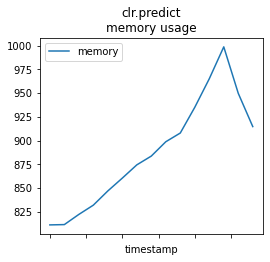

In [22]:
import matplotlib.pyplot as plt
from pandas import DataFrame, to_datetime

def mem_profile_plot(mem, title):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    df = DataFrame(mem, columns=["memory", "timestamp"])
    df["timestamp"] = to_datetime(df.timestamp)
    df["timestamp"] -= df.timestamp.min()
    df.set_index("timestamp").plot(ax=ax)
    ax.set_title(title + "\nmemory usage")
    return ax

mem_profile_plot(memprof_skl, "clr.predict");

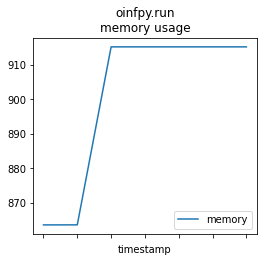

In [23]:
memprof_onx = memory_usage((oinfpy.run, ({'X': X_test32}, )), timestamps=True, interval=0.01)
mem_profile_plot(memprof_onx, "oinfpy.run");

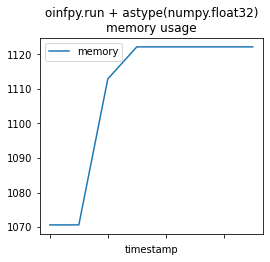

In [24]:
memprof_onx2 = memory_usage((oinfpy.run, ({'X': X_test.astype(numpy.float32, copy=False)}, )),
                           timestamps=True, interval=0.01)
mem_profile_plot(memprof_onx2, "oinfpy.run + astype(numpy.float32)");

This is not very informative.

## Memory profiling outside the notebook

More precise.

In [25]:
%%writefile mprof_clr_predict.py

import numpy
N, nfeat = 300000, 200
X = numpy.random.random((N, nfeat))
y = numpy.empty((N, 50))
for i in range(y.shape[1]):
    y[:, i] = X.sum(axis=1) + numpy.random.random(N)
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1)   

from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)

from sklearn import set_config
set_config(assume_finite=True)    

from memory_profiler import profile
@profile
def clr_predict():
    clr.predict(X_test)
    
clr_predict()

Overwriting mprof_clr_predict.py


In [26]:
!python -m memory_profiler mprof_clr_predict.py --timestamp

Filename: mprof_clr_predict.py

Line #    Mem usage    Increment   Line Contents
    20   1234.7 MiB   1234.7 MiB   @profile
    21                             def clr_predict():

The notebook seems to increase the memory usage.

In [27]:
%%writefile mprof_onnx_run.py

import numpy
N, nfeat = 300000, 200
X = numpy.random.random((N, nfeat))
y = numpy.empty((N, 50))
for i in range(y.shape[1]):
    y[:, i] = X.sum(axis=1) + numpy.random.random(N)
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1)   

from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)

from mlprodict.onnx_conv import to_onnx
from mlprodict.onnxrt import OnnxInference
clr_onnx = to_onnx(clr, X_train[:1].astype(numpy.float32))
oinfpy = OnnxInference(clr_onnx, runtime='python')
X_test32 = X_test.astype(numpy.float32)

from sklearn import set_config
set_config(assume_finite=True)    

from memory_profiler import profile
@profile
def oinfpy_predict():
    oinfpy.run({'X': X_test32})
    
oinfpy_predict()

Overwriting mprof_onnx_run.py


In [28]:
!python -m memory_profiler mprof_onnx_run.py --timestamp

Filename: mprof_onnx_run.py

Line #    Mem usage    Increment   Line Contents
    26   1498.8 MiB   1498.8 MiB   @profile
    27                             def oinfpy_predict():
    28   1500.1 MiB      1.3 MiB       oinfpy.run({'X': X_test32})




In [29]:
%%writefile mprof_onnx_run32.py

import numpy
N, nfeat = 300000, 200
X = numpy.random.random((N, nfeat))
y = numpy.empty((N, 50))
for i in range(y.shape[1]):
    y[:, i] = X.sum(axis=1) + numpy.random.random(N)
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1)   

from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)

from mlprodict.onnx_conv import to_onnx
from mlprodict.onnxrt import OnnxInference
clr_onnx = to_onnx(clr, X_train[:1].astype(numpy.float32))
oinfpy = OnnxInference(clr_onnx, runtime='python')

from sklearn import set_config
set_config(assume_finite=True)    

from memory_profiler import profile
@profile
def oinfpy_predict32():
    oinfpy.run({'X': X_test.astype(numpy.float32)})
    
oinfpy_predict32()

Overwriting mprof_onnx_run32.py


In [30]:
!python -m memory_profiler mprof_onnx_run32.py --timestamp

Filename: mprof_onnx_run32.py

Line #    Mem usage    Increment   Line Contents
    25   1293.1 MiB   1293.1 MiB   @profile
    26                             def oinfpy_predict32():
    27   1294.4 MiB      1.3 MiB       oinfpy.run({'X': X_test.astype(numpy.float32)})


